In [12]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import get_dataset_imagenet, imagenet_classes
from os.path import join

import matplotlib as mpl
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from functools import partial
from multiprocessing import RawArray, Pool
pmap = p_map

import PIL
import PIL.Image
from tqdm.auto import tqdm

rng = np.random.default_rng(2)

In [1]:
!ls ../processed/imagenet/resnet50/

locks  resnet50_imagenet_sketch  resnet50_imagenet_val


In [6]:
def get_dataset_imagenet(val_name):  
    from torchvision import datasets
    from torchvision.transforms import transforms
    default_data_paths = {
    'imagenet_val': '/home/jupyter/dist-shift/data/imagenet-val/',
    'imagenet_a': '/home/jupyter/dist-shift/data/...',
    'imagenet_r': '/home/jupyter/dist-shift/data/...',
    'imagenet_sketch': '/home/jupyter/dist-shift/data/sketch',
    'imagenet_v2': '/home/jupyter/dist-shift/data/...'
    }
    if val_name not in ['imagenet_val', 'imagenet_sketch']:
        raise NotImplementedError()
    datapath = default_data_paths[val_name]
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return datasets.ImageFolder(datapath, test_transforms)

In [5]:
gname = 'resnet50'
dname = 'imagenet_val' # or imagenet_sketch
classes = imagenet_classes

G = load_pickle(f'../processed/imagenet/resnet50/resnet50_{dname}')
dataset = get_dataset_imagenet(dname)
ytest = dataset.targets

## get it into standard form (index ordering)
for k in ['probs', 'freqs', 'labels', 'labels_err', 'points', 'points_err' ]:
    G[k] = np.moveaxis(G[k], 0, -1)
    print(f'G[{k}] shape: {G[k].shape}')

NUM_SAMPLES, NUM_CLASSES, NUM_CHECKPOINTS = G['probs'].shape

NameError: name 'datasets' is not defined

In [44]:
classes = imagenet_classes

In [34]:
G.keys()

dict_keys(['x', 'all_acc', 'x_err', 'all_acc_err', 'points', 'points_err', 'labels', 'labels_err', 'probs', 'freqs'])

In [35]:
G['probs'].shape

(50000, 1000, 40)

In [32]:
# for k in ['probs', 'freqs', 'labels', 'labels_err', 'points', 'points_err' ]:
#     G[k] = np.moveaxis(G[k], 0, -1)
#     print(f'G[{k}] shape: {G[k].shape}')

G[probs] shape: (50000, 1000, 40)
G[freqs] shape: (50000, 1000, 40)
G[labels] shape: (1000, 40)
G[labels_err] shape: (1000, 40)
G[points] shape: (50000, 40)
G[points_err] shape: (50000, 40)


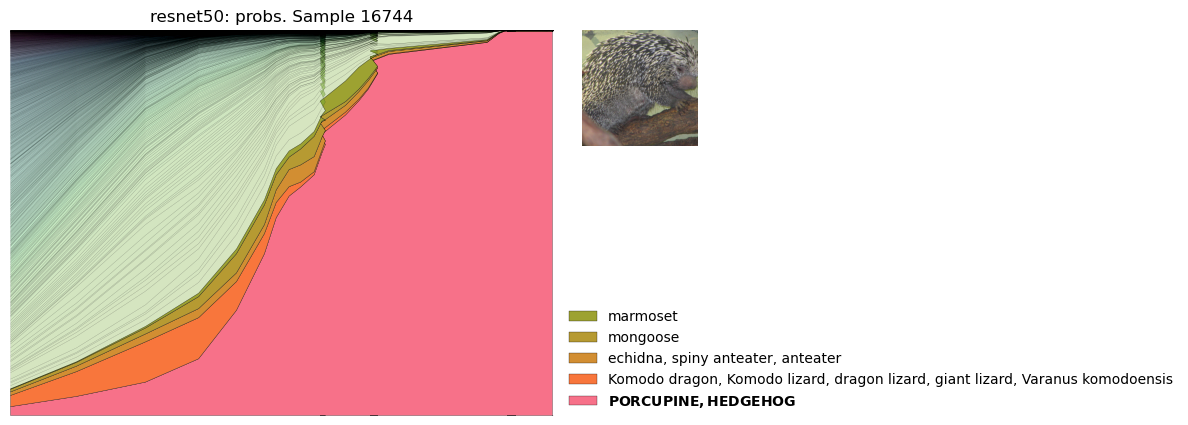

In [49]:
def stacksimple(i, x, prof, topk=5, ax=None):
    """
        i: index of image in dataset
        x: x-axis points
        prof: profile (NUM_LABELS, len(x))
        topk: number of "main" labels, for the legend.
    """
    true_label = ytest[i]
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals

    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        f, ax = plt.subplots(figsize=(7, 5))
        # f, ax = plt.subplots(figsize=(3, 2))
    
    # colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    # cm = sns.color_palette('rainbow', as_cmap=True)
    # fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    # colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    cp = 0.3 # fraction of color space to take up with topk
    c1, c2 = np.linspace(0, cp, topk, endpoint=False), np.linspace(cp, 1, len(ind)-topk)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    cm = sns.color_palette('husl', as_cmap=True)
    colors = [cm(v) for v in c1] + [fix_alpha(cm(v)) for v in c2]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.2))
        s.set_linewidth(0.2)

    for s in stacks[:topk]:
        s.set_edgecolor((0,0,0, 0.7))
        s.set_linewidth(0.3)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' '), labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    ax.set_axis_off()  
    sns.despine()
    
    ax2 = ax.inset_axes([1.01, 0.7, 0.3, 0.3], aspect='equal')
    ax2.set_axis_off()
    ax2.imshow(dataset[i][0])
    
    return ax.figure


## parameters
t = 'probs'
smooth = True

## generate plot
xkey = 'x'
x = G[xkey]

i = rng.choice(range(NUM_SAMPLES)) # random image index
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'

yy = G[t][i]
if smooth:
    for j in range(len(yy)):
        yy[j] = gaussian_filter1d(yy[j], sigma=1.0)
    
f = stacksimple(i, x, yy) # the actual plot
f.axes[0].set_title(f'{gname}: {t}. Sample {i}');
f

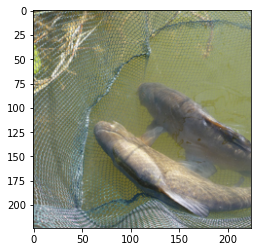

In [18]:
plt.imshow(dataset[0][0])